<a href="https://colab.research.google.com/github/Viraj465/Machine-learning-projects/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

developing a GAN for generating images requires both a *discriminator convolutional neural network model for classifying whether a given image is real or generated* and a *generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values*.

# GANs for developing real and fake Images
How to define and train the standalone discriminator model for learning
the difference between real and fake images.<br>
******************************************
How to define the standalone generator model and train the composite generator and discriminator model.<br>
******************************************
How to evaluate the performance of the GAN and use the final standalone generator model
to generate new images.

1. Dataset
2. How to Define and Train the Discriminator Model
3. How to Define and Use the Generator Model
4. How to Train the Generator Model
5. How to Evaluate GAN Model Performance
6. Complete Example of GAN for MNIST
7. How to Use the Final Generator Model

In [ ]:
import tf_keras
from tf_keras.datasets.fashion_mnist import load_data
import matplotlib.pylab as plt
import numpy as np
from tf_keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose
from tf_keras.optimizers import Adam

In [ ]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


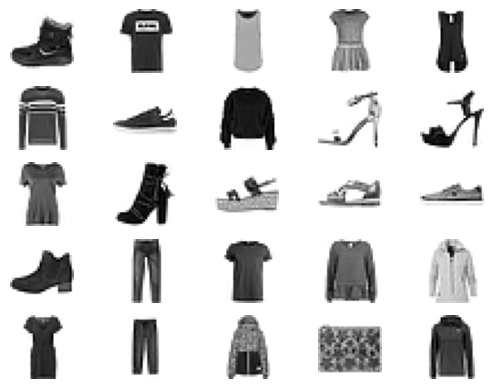

In [ ]:
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.axis('off')
  plt.imshow(trainX[i], cmap='gray_r')
plt.show()

In [ ]:

def define_discriminator(in_shape = (28,28,1)):
  layers = [Conv2D(64, (3,3), padding = 'same',strides = (2,2), input_shape = in_shape),
            LeakyReLU(alpha=0.2), Dropout(0.4),
            Conv2D(64, (3,3), padding = 'same',strides = (2,2)), LeakyReLU(alpha=0.2), Dropout(0.4),
            Conv2D(32, (3,3), padding = 'same',strides = (2,2)), LeakyReLU(alpha=0.2), Dropout(0.4),
            Flatten(),
            Dense(1,activation='sigmoid')]

  model = tf_keras.Sequential(layers)
  # compile model with {Adam SGD}
  opt = Adam(learning_rate = 0.0002,beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          1

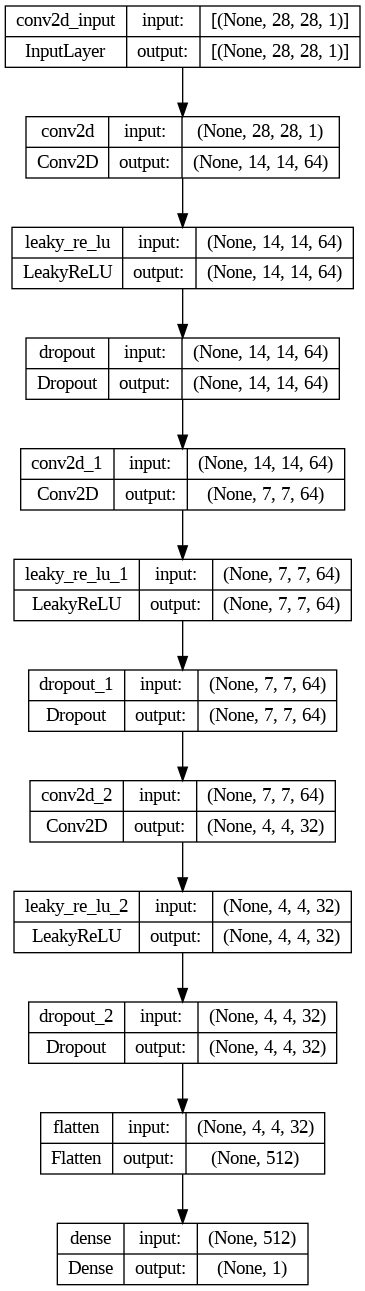

In [ ]:
dis_model = define_discriminator()
dis_model.summary()
# plot the model
tf_keras.utils.plot_model(dis_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)


**Training of the Discriminator Model**

Finally, we must scale the pixel values from the range of unsigned integers in [0,255] to the
normalized range of [0,1]. It is best practice to use the range [-1,1], but in this case the range
[0,1] works just fine.


In [ ]:
def load_real_samples():
  #  just use the input part of the training dataset as the real images.
  (trainX, _), (_, _) = load_data()
  #  images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of
  # images as input, where each image has one or more channels
  X = np.expand_dims(trainX, axis=-1)
  # convert from unsigned ints to floats
  X = X.astype('float32')
  # scale from [0,255] to [0,1]
  X = X / 255.0
  return X

In [ ]:
# select real random samples for training for each epoch
def generate_real_samples(dataset, n_samples):
  ix = np.random.randint(0,dataset.shape[0],n_samples)
  # retrieve data
  X= dataset[ix]
  y = np.ones((n_samples,1))
  return X, y

'''generate images comprised of random pixel values, specifically random pixel values
in the range [0,1] like our scaled real images'''

def generate_fake_samples(n_samples):
  X = np.random.rand(28*28*n_samples)
  X = X.reshape((n_samples, 28, 28, 1))
  y = np.zeros((n_samples,1))
  return X, y

In [ ]:
def visualize_fake_samples(fake_samples, n_samples=10):
    # Normalize images for display
    fake_samples = (fake_samples + 1) / 2.0

    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.axis('off')
        plt.imshow(fake_samples[i, :, :, 0], cmap='gray_r')

    plt.show()

<h3>Train discrimnator model</h3>

In [ ]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256,visualize_interval=10):
  half_batch = int(n_batch / 2)
  #  manually enumerate epochs
  for i in range(n_iter):
    # get randomly selected 'real' samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
    # update discriminator model weights on real samples
    _ , real_acc = model.train_on_batch(X_real, y_real)
    # get generated 'fake' samples
    X_fake, y_fake = generate_fake_samples(half_batch)
    # update discriminator model weights on fake samples
    _ , fake_acc = model.train_on_batch(X_fake, y_fake)

    #  summarize performance
    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
     # Visualize fake images at specified intervals
    if (i + 1) % visualize_interval == 0:
        visualize_fake_samples(X_fake)

>1 real=74% fake=7%
>2 real=83% fake=10%
>3 real=77% fake=9%
>4 real=80% fake=14%
>5 real=80% fake=18%
>6 real=80% fake=27%
>7 real=76% fake=34%
>8 real=79% fake=40%
>9 real=70% fake=44%
>10 real=77% fake=42%


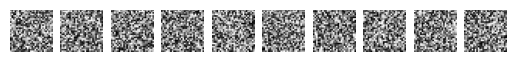

>11 real=73% fake=61%
>12 real=78% fake=62%
>13 real=80% fake=62%
>14 real=70% fake=67%
>15 real=73% fake=79%
>16 real=73% fake=79%
>17 real=68% fake=84%
>18 real=71% fake=88%
>19 real=62% fake=90%
>20 real=70% fake=91%


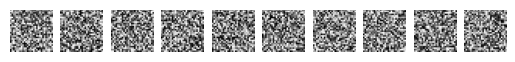

>21 real=68% fake=91%
>22 real=63% fake=90%
>23 real=66% fake=92%
>24 real=66% fake=95%
>25 real=70% fake=96%
>26 real=68% fake=98%
>27 real=73% fake=98%
>28 real=70% fake=98%
>29 real=72% fake=100%
>30 real=73% fake=100%


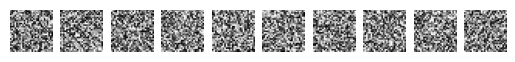

>31 real=67% fake=99%
>32 real=76% fake=98%
>33 real=84% fake=98%
>34 real=76% fake=100%
>35 real=75% fake=97%
>36 real=78% fake=99%
>37 real=78% fake=98%
>38 real=84% fake=99%
>39 real=76% fake=98%
>40 real=84% fake=99%


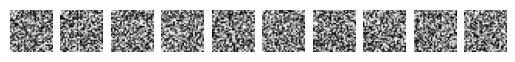

>41 real=90% fake=97%
>42 real=83% fake=97%
>43 real=86% fake=98%
>44 real=82% fake=98%
>45 real=91% fake=100%
>46 real=89% fake=99%
>47 real=93% fake=100%
>48 real=88% fake=98%
>49 real=91% fake=100%
>50 real=91% fake=99%


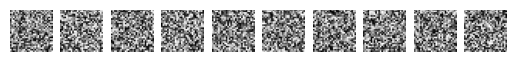

>51 real=89% fake=99%
>52 real=90% fake=98%
>53 real=95% fake=98%
>54 real=93% fake=98%
>55 real=94% fake=98%
>56 real=95% fake=99%
>57 real=91% fake=100%
>58 real=95% fake=99%
>59 real=94% fake=98%
>60 real=95% fake=100%


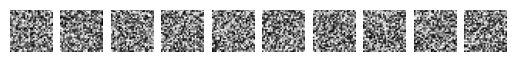

>61 real=96% fake=99%
>62 real=96% fake=100%
>63 real=92% fake=98%
>64 real=94% fake=100%
>65 real=98% fake=100%
>66 real=95% fake=100%
>67 real=97% fake=100%
>68 real=96% fake=100%
>69 real=97% fake=98%
>70 real=96% fake=98%


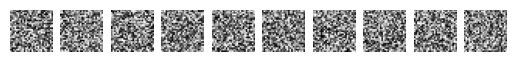

>71 real=98% fake=99%
>72 real=98% fake=98%
>73 real=97% fake=99%
>74 real=95% fake=99%
>75 real=97% fake=99%
>76 real=99% fake=100%
>77 real=95% fake=100%
>78 real=96% fake=100%
>79 real=98% fake=98%
>80 real=96% fake=100%


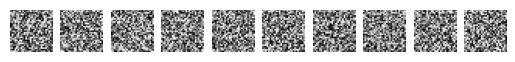

>81 real=98% fake=99%
>82 real=98% fake=100%
>83 real=99% fake=100%
>84 real=97% fake=100%
>85 real=98% fake=100%
>86 real=96% fake=100%
>87 real=98% fake=100%
>88 real=100% fake=100%
>89 real=98% fake=100%
>90 real=98% fake=100%


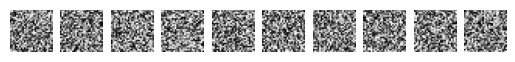

>91 real=98% fake=100%
>92 real=100% fake=100%
>93 real=99% fake=100%
>94 real=99% fake=100%
>95 real=97% fake=100%
>96 real=98% fake=100%
>97 real=99% fake=100%
>98 real=100% fake=100%
>99 real=98% fake=100%
>100 real=100% fake=100%


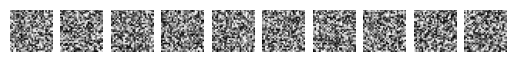

In [ ]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

<h3>Define the Generator Model</h3>

generator model is responsible for creating new, fake but plausible images.
does this by taking a point from the latent space as input and outputting a square grayscale image
<br>
❼ Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.<br>
❼ Outputs: Two-dimensional square grayscale image of 28 × 28 pixels with pixel values in
[0,1].

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 128)       262272    
 Transpose)                                           

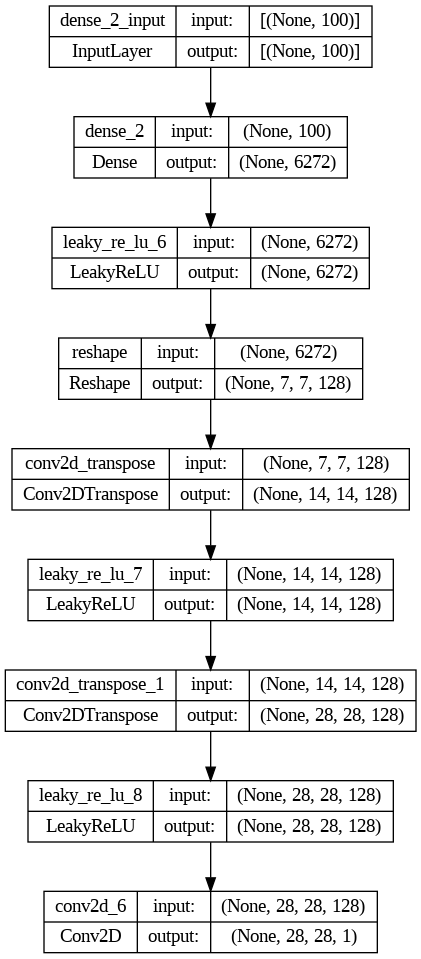

In [ ]:
# Define the standalone Generator Model

def define_generator(latent_dim):
  n_nodes = 128*7*7
  layers = [Dense(n_nodes,input_dim = latent_dim),LeakyReLU(0.2),Reshape((7,7,128)), #foundation for 7*7 image
            tf_keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),  # upsample to 14*14
            LeakyReLU(0.2),
            tf_keras.layers.Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'),  # upsample to 28*28
            LeakyReLU(0.2),
            Conv2D(1, (7,7), activation = 'sigmoid', padding = 'same')]
  model = tf_keras.Sequential(layers)
  return model

# define the size of the latent space
latent_dim = 100
# define the generator model
gen_model = define_generator(latent_dim)
# summarize the model
gen_model.summary()
# plot the model
tf_keras.utils.plot_model(gen_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

1/1 [==============================] - 2s 2s/step


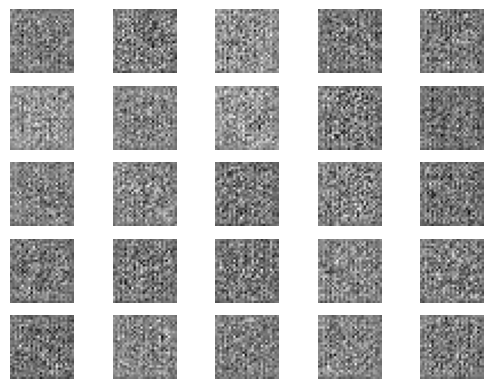

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
  # generate points in the latent space
  x_input = np. random.randn(latent_dim * n_samples)
  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  X = g_model.predict(x_input)
  # create ✬fake✬ class labels (0)
  y = np.zeros((n_samples, 1))
  return X, y

  # generate samples
n_samples = 25
X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
# define subplot
  plt.subplot(5, 5, 1 + i)
  # turn off axis labels
  plt.axis('off')
  # plot single image
  plt.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
plt.show()


**When the discriminator is good at detecting fake samples, the generator is updated more,
and when the discriminator model is relatively poor or confused when detecting fake samples,
the generator model is updated less. This defines the zero-sum or adversarial relationship
between these two models**

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 56545     
                                                                 
Total params: 1220834 (4.66 MB)
Trainable params: 1164289 (4.44 MB)
Non-trainable params: 56545 (220.88 KB)
_________________________________________________________________


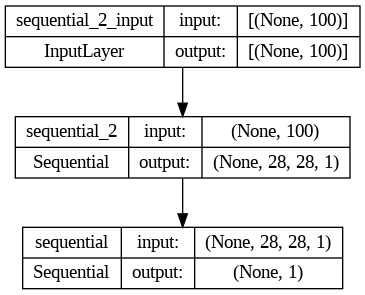

In [ ]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(g_model,d_model):
  # make weights of discriminator not trainable
  d_model.trainable = False
  layers = [g_model, d_model]
  model = tf_keras.Sequential(layers)
  opt = Adam(learning_rate = 0.0002,beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt)
  return model

gan_model = define_gan(gen_model, dis_model)
# summarize gan model
gan_model.summary()
# plot gan model
tf_keras.utils.plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Updating generator leaving discriminator default

def train_gan(gan_model,latent_dim, n_epochs=100,n_batch=256):
  for i in range(n_epochs):
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, n_batch)
    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    # update generator via the discriminators error
    gan_model.train_on_batch(x_gan, y_gan)


In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()


In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(x_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch + 1)
  g_model.save(filename)


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
  bat_per_epoch = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  # manually enumerate epochs
  for i in range(n_epochs):
  # enumerate batches over the training set
    for j in range(bat_per_epoch):
      # get randomly selected ✬real✬ samples
      X_real, y_real = generate_real_samples(dataset, half_batch)
      # generate ✬fake✬ examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # create training set for the discriminator
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)
      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator✬s error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epoch, d_loss, g_loss))
      # evaluate the model performance, sometimes
      if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)


In [ ]:
gan_model = define_gan(gen_model, dis_model)
# load image data
dataset = load_real_samples()
# train model
train(gen_model, dis_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 5ms/step
>1, 1/234, d=0.693, g=0.724
4/4 [==============================] - 0s 4ms/step
>1, 2/234, d=0.691, g=0.739
4/4 [==============================] - 0s 4ms/step
>1, 3/234, d=0.685, g=0.744
4/4 [==============================] - 0s 4ms/step
>1, 4/234, d=0.685, g=0.740
4/4 [==============================] - 0s 4ms/step
>1, 5/234, d=0.683, g=0.746
4/4 [==============================] - 0s 4ms/step
>1, 6/234, d=0.682, g=0.750
4/4 [==============================] - 0s 5ms/step
>1, 7/234, d=0.673, g=0.747
4/4 [==============================] - 0s 4ms/step
>1, 8/234, d=0.680, g=0.749
4/4 [==============================] - 0s 4ms/step
>1, 9/234, d=0.674, g=0.752
4/4 [==============================] - 0s 4ms/step
>1, 10/234, d=0.671, g=0.746
4/4 [==============================] - 0s 4ms/step
>1, 11/234, d=0.664, g=0.743
4/4 [==============================] - 0s 4ms/step
>1, 12/234, d=0.668, g=0.734
4/4 [==============================] - 0s 4ms/ste

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 5ms/step
>10, 2/234, d=0.681, g=0.709
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 64%, fake: 74%


4/4 [==============================] - 0s 5ms/step
>10, 3/234, d=0.680, g=0.694
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 90%, fake: 39%


4/4 [==============================] - 0s 5ms/step
>10, 4/234, d=0.671, g=0.692
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 85%, fake: 31%


4/4 [==============================] - 0s 4ms/step
>10, 5/234, d=0.676, g=0.683
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 92%, fake: 25%


4/4 [==============================] - 0s 5ms/step
>10, 6/234, d=0.681, g=0.687
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 93%, fake: 27%


4/4 [==============================] - 0s 5ms/step
>10, 7/234, d=0.674, g=0.682
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 92%, fake: 30%


4/4 [==============================] - 0s 5ms/step
>10, 8/234, d=0.678, g=0.686
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 89%, fake: 35%


4/4 [==============================] - 0s 4ms/step
>10, 9/234, d=0.688, g=0.685
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 86%, fake: 42%


4/4 [==============================] - 0s 5ms/step
>10, 10/234, d=0.682, g=0.684
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 87%, fake: 27%


4/4 [==============================] - 0s 4ms/step
>10, 11/234, d=0.688, g=0.686
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 75%, fake: 36%


4/4 [==============================] - 0s 5ms/step
>10, 12/234, d=0.672, g=0.688
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 81%, fake: 37%


4/4 [==============================] - 0s 4ms/step
>10, 13/234, d=0.685, g=0.709
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 56%, fake: 63%


4/4 [==============================] - 0s 5ms/step
>10, 14/234, d=0.689, g=0.729
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 54%, fake: 77%


4/4 [==============================] - 0s 5ms/step
>10, 15/234, d=0.686, g=0.742
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 38%, fake: 90%


4/4 [==============================] - 0s 5ms/step
>10, 16/234, d=0.687, g=0.760
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 20%, fake: 99%


4/4 [==============================] - 0s 5ms/step
>10, 17/234, d=0.684, g=0.799
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 14%, fake: 99%


4/4 [==============================] - 0s 6ms/step
>10, 18/234, d=0.684, g=0.769
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 19%, fake: 95%


4/4 [==============================] - 0s 4ms/step
>10, 19/234, d=0.685, g=0.769
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 36%, fake: 100%


4/4 [==============================] - 0s 5ms/step
>10, 20/234, d=0.681, g=0.748
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 44%, fake: 94%


4/4 [==============================] - 0s 5ms/step
>10, 21/234, d=0.684, g=0.723
4/4 [==============================] - 0s 9ms/step
>Accuracy real: 55%, fake: 81%


4/4 [==============================] - 0s 5ms/step
>10, 22/234, d=0.687, g=0.699
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 73%, fake: 48%


4/4 [==============================] - 0s 5ms/step
>10, 23/234, d=0.676, g=0.684
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 89%, fake: 32%


4/4 [==============================] - 0s 5ms/step
>10, 24/234, d=0.679, g=0.673
4/4 [==============================] - 0s 6ms/step
>Accuracy real: 94%, fake: 14%


4/4 [==============================] - 0s 5ms/step
>10, 25/234, d=0.682, g=0.664
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 99%, fake: 12%


4/4 [==============================] - 0s 4ms/step
>10, 26/234, d=0.677, g=0.679
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 95%, fake: 17%


4/4 [==============================] - 0s 5ms/step
>10, 27/234, d=0.684, g=0.680
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 95%, fake: 29%


4/4 [==============================] - 0s 5ms/step
>10, 28/234, d=0.674, g=0.701
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 84%, fake: 42%


4/4 [==============================] - 0s 5ms/step
>10, 29/234, d=0.683, g=0.709
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 72%, fake: 53%


4/4 [==============================] - 0s 5ms/step
>10, 30/234, d=0.689, g=0.723
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 69%, fake: 73%


4/4 [==============================] - 0s 5ms/step
>10, 31/234, d=0.685, g=0.749
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 46%, fake: 91%


4/4 [==============================] - 0s 4ms/step
>10, 32/234, d=0.677, g=0.750
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 35%, fake: 91%


4/4 [==============================] - 0s 4ms/step
>10, 33/234, d=0.671, g=0.754
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 34%, fake: 94%


4/4 [==============================] - 0s 5ms/step
>10, 34/234, d=0.668, g=0.740
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 46%, fake: 90%


4/4 [==============================] - 0s 5ms/step
>10, 35/234, d=0.685, g=0.728
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 60%, fake: 83%


4/4 [==============================] - 0s 5ms/step
>10, 36/234, d=0.687, g=0.723
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 69%, fake: 68%


4/4 [==============================] - 0s 5ms/step
>10, 37/234, d=0.685, g=0.689
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 89%, fake: 42%


4/4 [==============================] - 0s 5ms/step
>10, 38/234, d=0.678, g=0.675
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 92%, fake: 21%


4/4 [==============================] - 0s 5ms/step
>10, 39/234, d=0.672, g=0.677
4/4 [==============================] - 0s 7ms/step
>Accuracy real: 97%, fake: 22%


4/4 [==============================] - 0s 5ms/step
>10, 40/234, d=0.677, g=0.695
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 81%, fake: 49%


4/4 [==============================] - 0s 5ms/step
>10, 41/234, d=0.691, g=0.709
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 73%, fake: 62%


4/4 [==============================] - 0s 5ms/step
>10, 42/234, d=0.678, g=0.736
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 43%, fake: 96%


4/4 [==============================] - 0s 5ms/step
>10, 43/234, d=0.677, g=0.757
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 38%, fake: 93%


4/4 [==============================] - 0s 4ms/step
>10, 44/234, d=0.679, g=0.755
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 36%, fake: 95%


4/4 [==============================] - 0s 4ms/step
>10, 45/234, d=0.687, g=0.736
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 30%, fake: 91%


4/4 [==============================] - 0s 4ms/step
>10, 46/234, d=0.688, g=0.744
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 38%, fake: 96%


4/4 [==============================] - 0s 5ms/step
>10, 47/234, d=0.695, g=0.755
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 38%, fake: 95%


4/4 [==============================] - 0s 5ms/step
>10, 48/234, d=0.688, g=0.740
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 40%, fake: 93%


4/4 [==============================] - 0s 4ms/step
>10, 49/234, d=0.683, g=0.716
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 66%, fake: 67%


4/4 [==============================] - 0s 5ms/step
>10, 50/234, d=0.675, g=0.685
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 82%, fake: 33%


4/4 [==============================] - 0s 5ms/step
>10, 51/234, d=0.689, g=0.683
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 89%, fake: 29%


4/4 [==============================] - 0s 5ms/step
>10, 52/234, d=0.676, g=0.667
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 92%, fake: 25%


4/4 [==============================] - 0s 5ms/step
>10, 53/234, d=0.688, g=0.679
4/4 [==============================] - 0s 5ms/step
>Accuracy real: 93%, fake: 36%


4/4 [==============================] - 0s 5ms/step
>10, 54/234, d=0.680, g=0.688
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 91%, fake: 33%


4/4 [==============================] - 0s 5ms/step
>10, 55/234, d=0.680, g=0.693
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 74%, fake: 41%


4/4 [==============================] - 0s 6ms/step
>10, 56/234, d=0.694, g=0.738
4/4 [==============================] - 0s 7ms/step
>Accuracy real: 49%, fake: 75%


4/4 [==============================] - 0s 5ms/step
>10, 57/234, d=0.677, g=0.746
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 40%, fake: 91%


4/4 [==============================] - 0s 5ms/step
>10, 58/234, d=0.677, g=0.780
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 25%, fake: 94%


4/4 [==============================] - 0s 5ms/step
>10, 59/234, d=0.688, g=0.783
4/4 [==============================] - 0s 6ms/step
>Accuracy real: 22%, fake: 98%


4/4 [==============================] - 0s 5ms/step
>10, 60/234, d=0.677, g=0.792
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 23%, fake: 99%


4/4 [==============================] - 0s 5ms/step
>10, 61/234, d=0.689, g=0.759
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 31%, fake: 93%
